# USAGE EXAMPLES FOR SIMPLESEDML

This notebook provides examples of using ``SimpleSBML``.

The initial emphasize is on time course simulations. A ``SingleModelTimeCourse`` object has one required parameter, the model. This can be an Antimony or SBML string or file or a URL. There are optional parameters related to the simulation and changing values of the paramters of the model. It has the following methods:
* ``getSEDML``
* ``getPhraSEDML``
* ``execute``: returns a ``DataFrame`` and a plot of the variables specified in the constructor.
* ``makeOMEXFile`` creates an omex file

A ``MultipleModelTimeCourseObject`` has the same arguments as for ``SingleModelTimeCourse`` except that the one required argument is a list of models. It has the same methods as well. The only difference is that there is one plot for each variable specified in the constructor with a curve for each model.

Some use cases are:
1. Iteratively develop SEDML by use execute, and then generate desired SEDML.
2. Generate PhraSEDML, edit it, and then generate SEDML from these edits.

In [1]:
# Handle execution locally, in github actions, and in Colab
import sys
sys.path.insert(0, "'/Users/jlheller/home/Technical/repos/SimpleSEDML/src'")
try:
    import SimpleSEDML as ss
except:
    !pip install SimpleSEDML
    import SimpleSEDML as ss
import pandas as pd

/Users/jlheller/home/Technical/repos/SimpleSEDML/ssed/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Collect paths of files creates
MODEL_SOURCES = []

# Model

In [3]:
MODEL_ANT = '''
model myModel
    J1: S1 -> S2; k1*S1
    J2: S2 -> S3; k2*S2
    
    S1 = 10
    S2 = 0
    k1 = 1
    k2 = 1
end
'''

In [4]:
MODEL2_ANT = '''
model myModel
    J1: S1 -> S2; k1*S1
    J2: S2 -> S3; k2*S2
    J3: S3 -> S1; k3*S3
    
    S1 = 10
    S2 = 0
    k1 = 1
    k2 = 1
    k3 = 0.1
end
'''

In [5]:
IS_PLOT = True

In [6]:
if IS_PLOT:
    dir(ss)

# Use Case 1: Single model with default arguments

In [7]:
if IS_PLOT:
    ?ss.makeSingleModelTimeCourse

Signature:
ss.makeSingleModelTimeCourse(
    model_ref: str,
    ref_type: Optional[str] = None,
    display_variables: Optional[List[str]] = None,
    start: float = 0,
    end: float = 5,
    num_step: Optional[int] = None,
    num_point: Optional[int] = None,
    time_course_id: Optional[str] = None,
    title: Optional[str] = None,
    algorithm: Optional[str] = None,
    is_plot: bool = True,
    **parameter_dct,
) -> SimpleSEDML.single_model_time_course.SingleModelTimeCourse
Docstring:
Creates a time course simulation

Args:
    model_ref: reference to the model
    ref_type: type of the reference (e.g. "sbml_str", "ant_str", "sbml_file", "ant_file", "sbml_url")
    display_variables: variables to be plotted
    start: start time
    end: end time
    num_step: number of steps
    time_course_id: ID of the time course simulation
    algorithm: algorithm to use for the simulation
    title: title of the plot
    is_plot: if True, plot the results
    parameter_dct: parameters to b

In [8]:
smtc = ss.makeSingleModelTimeCourse(MODEL_ANT, title="My Plot", num_point=100, is_plot=IS_PLOT)

In [9]:
if IS_PLOT:
    print(smtc.getSEDML())

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="time_course_model" language="urn:sedml:language:sbml.level-3.version-2" source="/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpzadu416u/time_course_model.xml"/>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="time_course_sim" initialTime="0" outputStartTime="0" outputEndTime="5" numberOfSteps="99">
      <algorithm name="CVODE" kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfTasks>
    <task id="time_course_task" modelReference="time_course_model" simulationReference="time_course_sim"/>
  </listOfTasks>
  <listOfDataGenerators>
    <dataGenerator id="report_0_0_0" name="time">
      <math xmlns="http://www.w3.org/1998/Math/MathML">
        <ci> time

We can also look at the PhraSED-ML that gets generated by changing the object that gets returned.

In [10]:
if IS_PLOT:
    print(smtc.getPhraSEDML())

time_course_model = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpzadu416u/time_course_model.xml" 
time_course_sim = simulate uniform(0, 5, 99)
time_course_sim.algorithm = CVODE
time_course_task = run time_course_sim on time_course_model
report time, S1, S2, S3
plot "My Plot" time vs S1, S2, S3


And we can execute the SEDML, getting both a plot and a DataFrame of time course values.

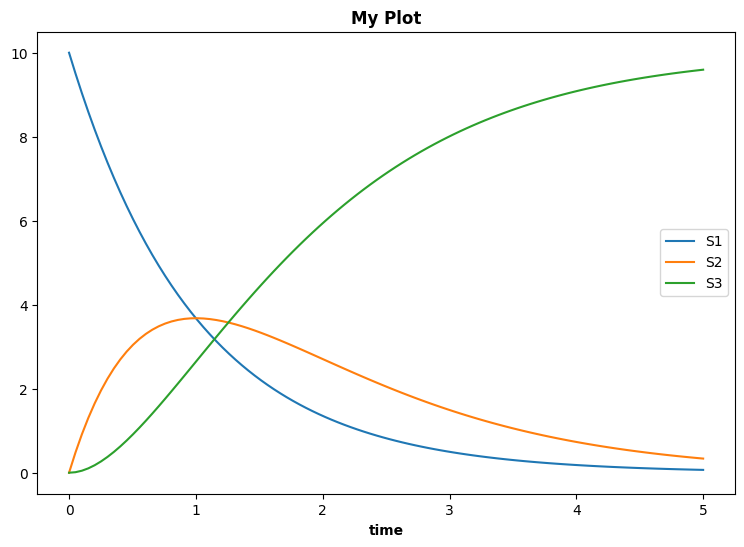

In [11]:
df = smtc.execute()

In [12]:
if IS_PLOT:
    df.head()

In [13]:
MODEL_SOURCES.extend(smtc.model_sources)

# Use Case 2: Single model with non-default arguments

In [14]:
WOLF_URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL3352181362/3/BIOMD0000000206_url.xml"

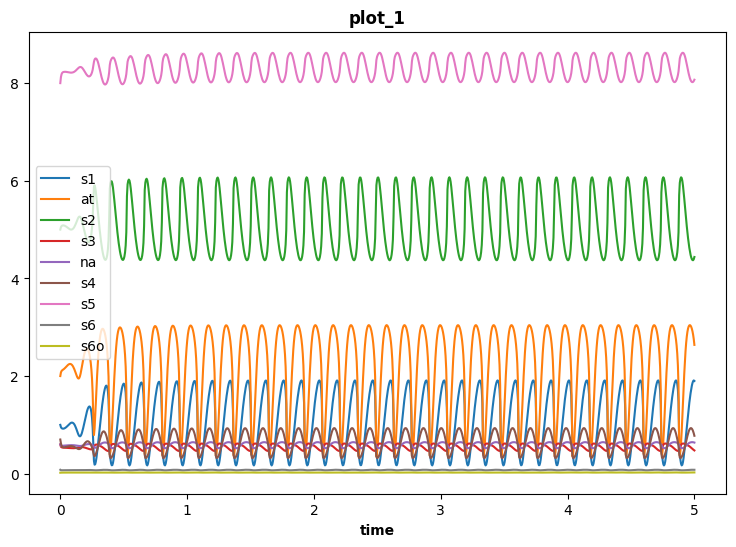

In [15]:
smtc = ss.makeSingleModelTimeCourse(WOLF_URL, num_point=1000, is_plot=IS_PLOT)
MODEL_SOURCES.extend(smtc.model_sources)
_ = smtc.execute()

In [16]:
if IS_PLOT:
    ss.getModelInformation(WOLF_URL)

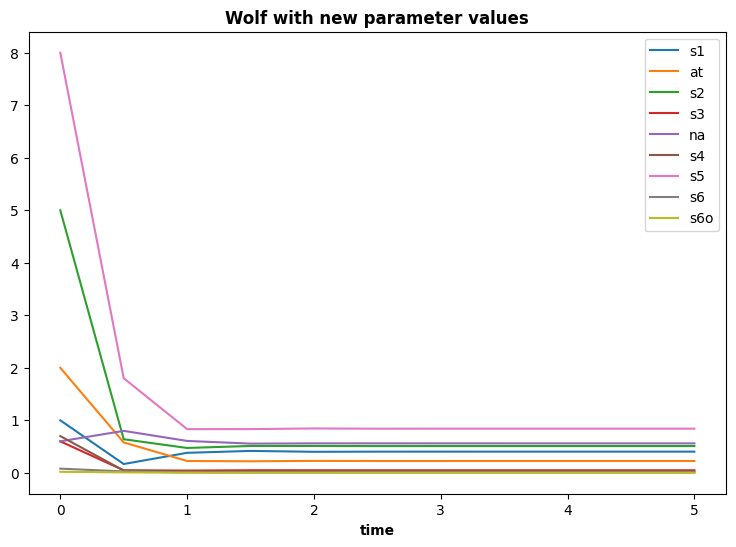

In [17]:
smtc = ss.makeSingleModelTimeCourse(WOLF_URL, k0=5, k1=55, title="Wolf with new parameter values",
        is_plot=IS_PLOT)
df = smtc.execute()

In [18]:
if IS_PLOT:
    df.head()

In [19]:
MODEL_SOURCES.extend(smtc.model_sources)

# Use Case 3: Comparing the time course simulation of multiple models

When comparing the time course simulation of multiple models, we want to compare selected **display variables** from the models, either in plots or in a DataFrame. This is done with the  ``MultipleModelTimeCourse`` object.

In [20]:
mmtc = ss.makeMultipleModelTimeCourse([MODEL_ANT, MODEL2_ANT], k1=10, num_point=100,
                                     is_plot=IS_PLOT)

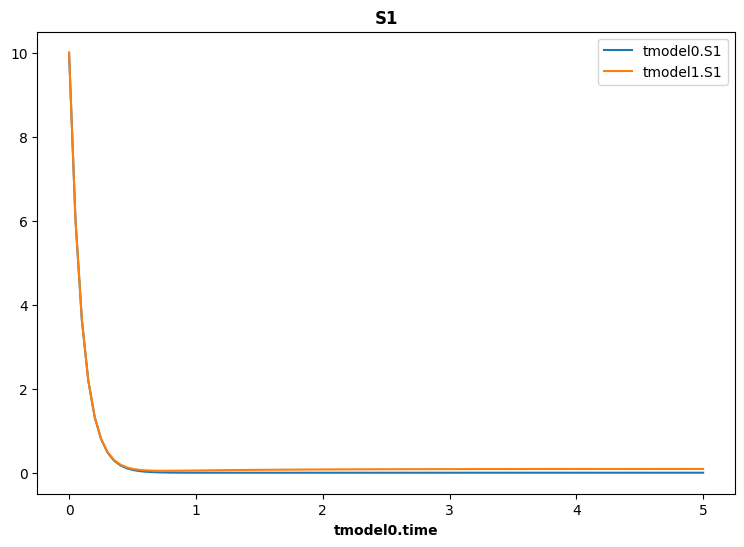

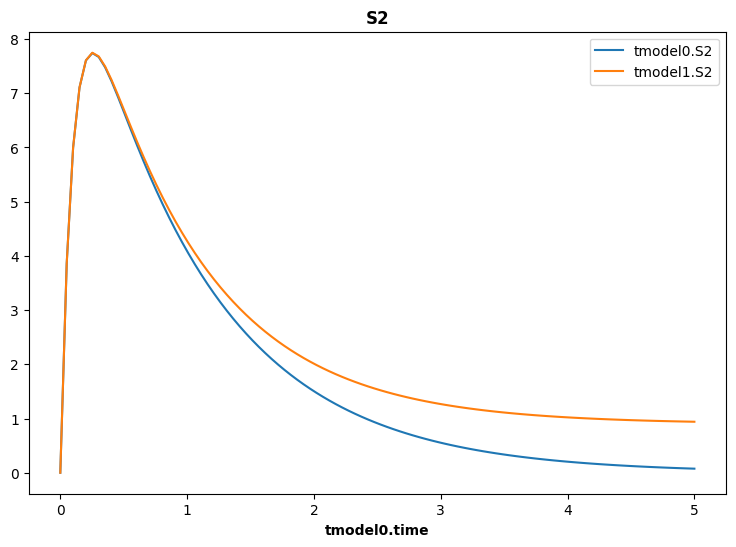

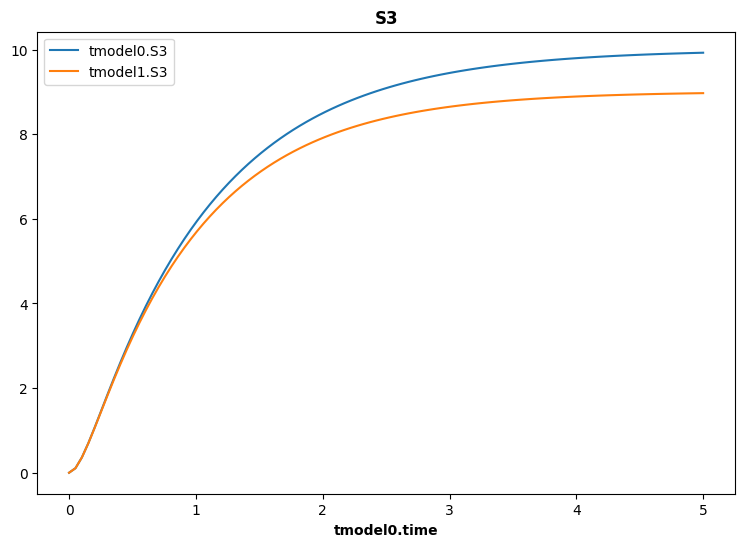

In [21]:
MODEL_SOURCES.extend(mmtc.model_sources)
if IS_PLOT:
    mmtc.execute()

In [22]:
if IS_PLOT:
    print(mmtc.getPhraSEDML())

model0 = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmp4urvfazk/model0.xml"  with k1 = 10
model1 = model "/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmp4urvfazk/model1.xml"  with k1 = 10
sim1 = simulate uniform(0, 5, 99)
sim1.algorithm = CVODE
tmodel0 = run sim1 on model0
tmodel1 = run sim1 on model1
report tmodel0.time, tmodel0.S1, tmodel1.S1, tmodel0.S2, tmodel1.S2, tmodel0.S3, tmodel1.S3
report tmodel0.time, tmodel0.S1, tmodel1.S1, tmodel0.S2, tmodel1.S2, tmodel0.S3, tmodel1.S3
plot "S1" tmodel0.time vs tmodel0.S1, tmodel1.S1
plot "S2" tmodel0.time vs tmodel0.S2, tmodel1.S2
plot "S3" tmodel0.time vs tmodel0.S3, tmodel1.S3


In [23]:
if IS_PLOT:
    print(mmtc.getSEDML())

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="model0" language="urn:sedml:language:sbml.level-3.version-2" source="/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmp4urvfazk/model0.xml">
      <listOfChanges>
        <changeAttribute target="/sbml:sbml/sbml:model/sbml:listOfParameters/sbml:parameter[@id='k1']/@value" newValue="10"/>
      </listOfChanges>
    </model>
    <model id="model1" language="urn:sedml:language:sbml.level-3.version-2" source="/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmp4urvfazk/model1.xml">
      <listOfChanges>
        <changeAttribute target="/sbml:sbml/sbml:model/sbml:listOfParameters/sbml:parameter[@id='k1']/@value" newValue="10"/>
      </listOfChanges>
    </model>
  </listOfModels>
  <listOfSimulations>
    <un

## Creating an OMEX file

We can create an OMEX file for this experiment.

In [24]:
omex_path, _ = mmtc.makeOMEXFile()
omex_path

'/Users/jlheller/home/Technical/repos/SimpleSEDML/examples/project.omex'

In [25]:
if IS_PLOT:
    !unzip -l project.omex

Archive:  project.omex
  Length      Date    Time    Name
---------  ---------- -----   ----
     1096  05-24-2025 09:07   metadata.rdf
     2230  05-24-2025 09:07   model0.xml
     2845  05-24-2025 09:07   model1.xml
     8163  05-24-2025 09:07   project.sedml
      584  05-24-2025 09:07   manifest.xml
---------                     -------
    14918                     5 files


In [26]:
MODEL_SOURCES.extend(mmtc.model_sources)

# Under construction: Compare several parameters at steady state for a single model

# Under construction: Compare stochastic simulations

# Under construction: Get data for several different simulations

In [27]:
# Compose an experiment
ssed = ss.SimpleSEDML()
ssed.addModel("model1", MODEL_ANT, parameter_dct=dict(k1=3), ref_type="ant_str", is_overwrite=True)
ssed.addSimulation("sim1", "uniform", start=0, end=1, num_step=50)
ssed.addTask("task1", "model1", "sim1")
ssed.addReport("time", "S1", "S2", "S3")
ssed.addPlot("time", "S2", title="my plot", is_plot=IS_PLOT)

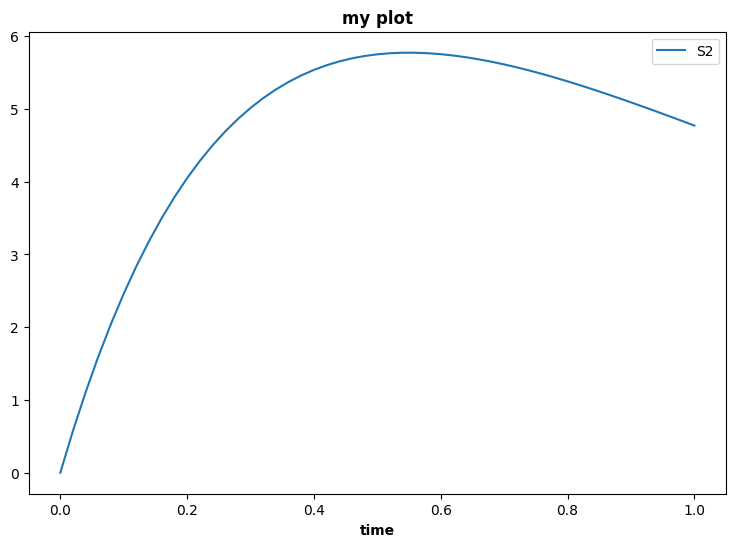

In [28]:
# Run the descript
df = ssed.execute()

In [29]:
if IS_PLOT:
    df.head(10)

In [30]:
ssed.getAllModelInformation()

{'model1': Model: myModel
 Parameters: {'k1': 1.0, 'k2': 1.0}
 Floating Species: {'S1': 10.0, 'S2': 0.0, 'S3': 0.0}
 Boundary Species: {}
 Number of Reactions: 2
 Number of Species: 3}

In [31]:
MODEL_SOURCES.extend(smtc.model_sources)

# Under construction: Repeated Tasks

At present, the Tellurium execution of SED-ML only provides access to the last report for repeated tasks.

In [32]:
# Make DataFrame of changes to model parameters
parameter_df = pd.DataFrame(dict(k1=[1, 3], k2=[1, 3]))

/Users/jlheller/home/Technical/repos/SimpleSEDML/src/SimpleSEDML/simple_sedml_base.py:283: UserWarning:

Reports only generate data for the last repeated task.



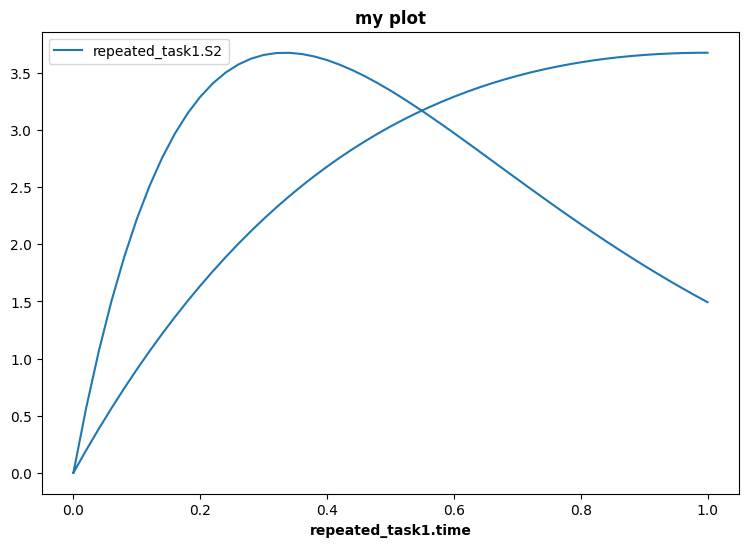

In [33]:
ssed = ss.SimpleSEDML()
ssed.addModel("model1", MODEL_ANT, parameter_dct=dict(k1=3), ref_type="ant_str", is_overwrite=True)
ssed.addSimulation("sim1", "uniform", start=0, end=1, num_step=50)
ssed.addTask("task1", "model1", "sim1")
ssed.addRepeatedTask("repeated_task1", "task1", parameter_df=parameter_df)
ssed.addReport("task1.time", "task1.S1", "task1.S2", "task1.S3")
ssed.addPlot("repeated_task1.time", "repeated_task1.S2", title="my plot", is_plot=IS_PLOT)
result_df = ssed.execute()

In [34]:
if IS_PLOT:
    print(ssed.getSEDML())

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by phraSED-ML version v1.3.0 with libSBML version 5.19.5. -->
<sedML xmlns="http://sed-ml.org/sed-ml/level1/version4" xmlns:sbml="http://www.sbml.org/sbml/level3/version2/core" level="1" version="4">
  <listOfModels>
    <model id="model1" language="urn:sedml:language:sbml.level-3.version-2" source="/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/tmpmx40qe2n/model1.xml">
      <listOfChanges>
        <changeAttribute target="/sbml:sbml/sbml:model/sbml:listOfParameters/sbml:parameter[@id='k1']/@value" newValue="3"/>
      </listOfChanges>
    </model>
  </listOfModels>
  <listOfSimulations>
    <uniformTimeCourse id="sim1" initialTime="0" outputStartTime="0" outputEndTime="1" numberOfSteps="50">
      <algorithm name="CVODE" kisaoID="KISAO:0000019"/>
    </uniformTimeCourse>
  </listOfSimulations>
  <listOfTasks>
    <task id="task1" modelReference="model1" simulationReference="sim1"/>
    <repeatedTask id="repeated_task1" range="vect

In [35]:
MODEL_SOURCES.extend(ssed.model_sources)

# Cleanup

In [36]:
import os
EXAMPLE_REMOVE_FILES = ["simple_sedml_plot.png", "project.omex", "project.omex"]
example_dir = os.getcwd()
remove_files = [os.path.join(example_dir, f) for f in EXAMPLE_REMOVE_FILES]
remove_files.extend(MODEL_SOURCES)
for ffile in remove_files:
    if os.path.isfile(ffile):
        os.remove(ffile)